In [128]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData
from astropy.io import fits 
import tqdm
import cmasher as cm
import os
import model_radial_old as model_radial
import astropy.units as u
from scipy import stats
jax.config.update("jax_enable_x64", True)

In [129]:
# LOAD THE DATA
path = '/Users/dhortad/Projects/TorusImaging-radial/data/qiso_df_sim_Rz.fits'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

10000000


In [224]:
# Eilers rotation curve
Rgal = data['R']*u.kpc
vcirc_eilers = 229.-1.7*(Rgal.value-8.275)
Rg = data['Rg']*u.kpc
lz = data['J'][:,1]*u.kpc**2/u.Myr
lz = lz.to((u.kpc*u.km)/u.s)
vcirc = 229. *u.km/u.s
# vcirc = 229.
deltaR = Rgal-Rg

#transform to cylindrical velocities

vR = data['v_R']*u.kpc/u.Myr
# vR = vR.to(u.km/u.s)

In [225]:
jr = data['J'][:,0]*u.kpc**2/u.Myr
jr = jr.to(u.km/u.s * u.kpc)

In [226]:
# popt = np.array([0.00040208, 0.03877531])
# lab = jr.value* popt[0] + popt[1]

def make_mgfe(JR, slope=0.1 / 10, std=0.05, rng=None):
    """
    Default parameters from APOGEE in fiducial model
    """
    if rng is None:
        rng = np.random.default_rng()

    x = np.sqrt(JR)
    mgfe = slope * x + 0.0
    mgfe = rng.normal(mgfe, std)
    mgfe_err = np.exp(rng.normal(-4.0, 0.5, size=len(JR)))
    mgfe = rng.normal(mgfe, mgfe_err)
    return mgfe, mgfe_err

lab, lab_err = make_mgfe(jr)

Text(0, 0.5, '$v_R$ [kpc/Myr]')

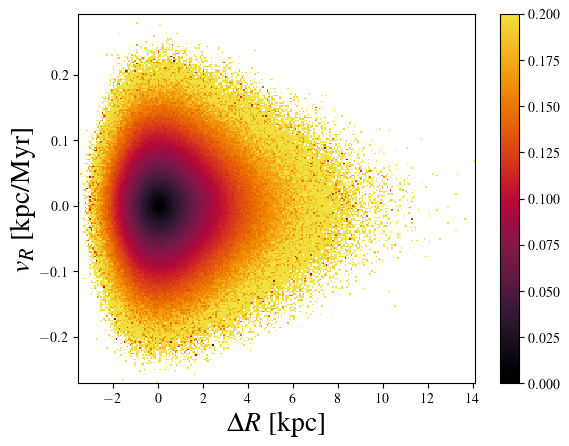

In [227]:
binx = np.linspace(np.min(deltaR),np.max(deltaR),256)
biny = np.linspace(np.min(vR.value),np.max(vR.value),256)    
hist = stats.binned_statistic_2d(deltaR.value,vR.value, lab, statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=0.0,vmax=0.2)
plt.colorbar()
plt.xlabel('$\Delta R$ [kpc]', fontsize=20)
plt.ylabel('$v_R$ [kpc/Myr]', fontsize=20)


Text(0, 0.5, '$v_R$ [kpc/Myr]')

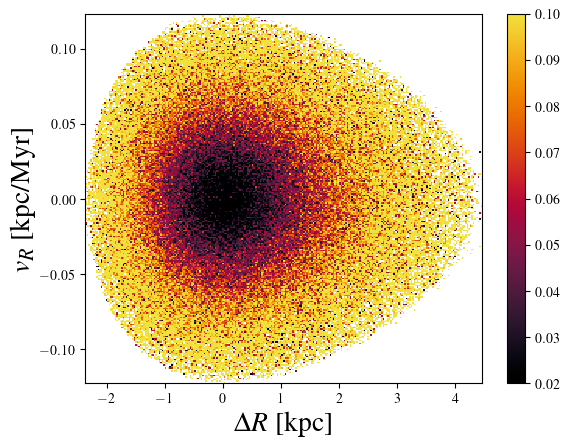

In [228]:
from scipy import stats
mask = (Rg > 8*u.kpc) & (Rg <= 9*u.kpc) & (np.abs(data['z'])<0.2) & (data['v_z']<0.03) &(jr.value<200)


binx = np.linspace(np.min(deltaR[mask]),np.max(deltaR[mask]),256)
biny = np.linspace(np.min(vR.value[mask]),np.max(vR.value[mask]),256)    
hist = stats.binned_statistic_2d(deltaR.value[mask],vR.value[mask], lab[mask], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember, vmin=0.02,vmax=0.1)
plt.colorbar()
plt.xlabel('$\Delta R$ [kpc]', fontsize=20)
plt.ylabel('$v_R$ [kpc/Myr]', fontsize=20)

# model the data

In [229]:
max_deltaR = 4 * u.kpc
max_vR = 0.15 * u.kpc / u.Myr
bins = {
    "pos": np.linspace(-1, 1, 81) * max_deltaR,
    "vel": np.linspace(-1, 1, 81) * max_vR,
}

In [230]:
x_param = deltaR 
y_param = vR 
label = lab
label_err = lab_err

bdata = oti.data.get_binned_label(
    pos=x_param.astype(np.float32),
    vel=y_param.astype(np.float32),
    label=label.astype(np.float32),
    label_err=label_err.astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=16,
)


In [250]:

# in simulation we see that it is a triangle, so include m=2,3,4 modes

# model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
#     bdata,
#     label_knots=8,
#     e_knots={2: 12, 3: 4, 4: 4},
#     label_l2_sigma=1.0,
#     label_smooth_sigma=0.5,
#     e_signs={3: -1.},
#     e_l2_sigmas={2: 1.0, 3: 1.0, 4: 1.0},
#     e_smooth_sigmas={2: 0.1, 3: 0.1, 4: 0.1},
#     dacc_strength=0.0,
#     label_knots_spacing_power=0.75,
#     e_knots_spacing_power=0.5,
# )


model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={1: 8, 2: 12, 3: 4, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    e_signs={1: -1, 3: -1},
    e_smooth_sigmas={1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1},
    dacc_strength=0.0,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
)


In [251]:
# init_params["e_params"][1]["vals"] = np.full_like(
#     init_params["e_params"][1]["vals"], np.log(0.1 / model._label_knots.max())
# )
# init_params["e_params"][2]["vals"] = np.full_like(
#     init_params["e_params"][2]["vals"], np.log(0.1 / model._label_knots.max())
# )
# init_params["e_params"][3]["vals"] = np.full_like(
#     init_params["e_params"][3]["vals"], np.log(0.1 / model._label_knots.max())
# )
# init_params["e_params"][4]["vals"] = np.full_like(
#     init_params["e_params"][4]["vals"], np.log(0.01 / model._label_knots.max())
# )

init_params["e_params"][1]["vals"] = np.full_like(
    init_params["e_params"][1]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -0.5
)
init_params["e_params"][3]["vals"] = np.full_like(
    init_params["e_params"][3]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
)

14it [01:37,  6.99s/it]


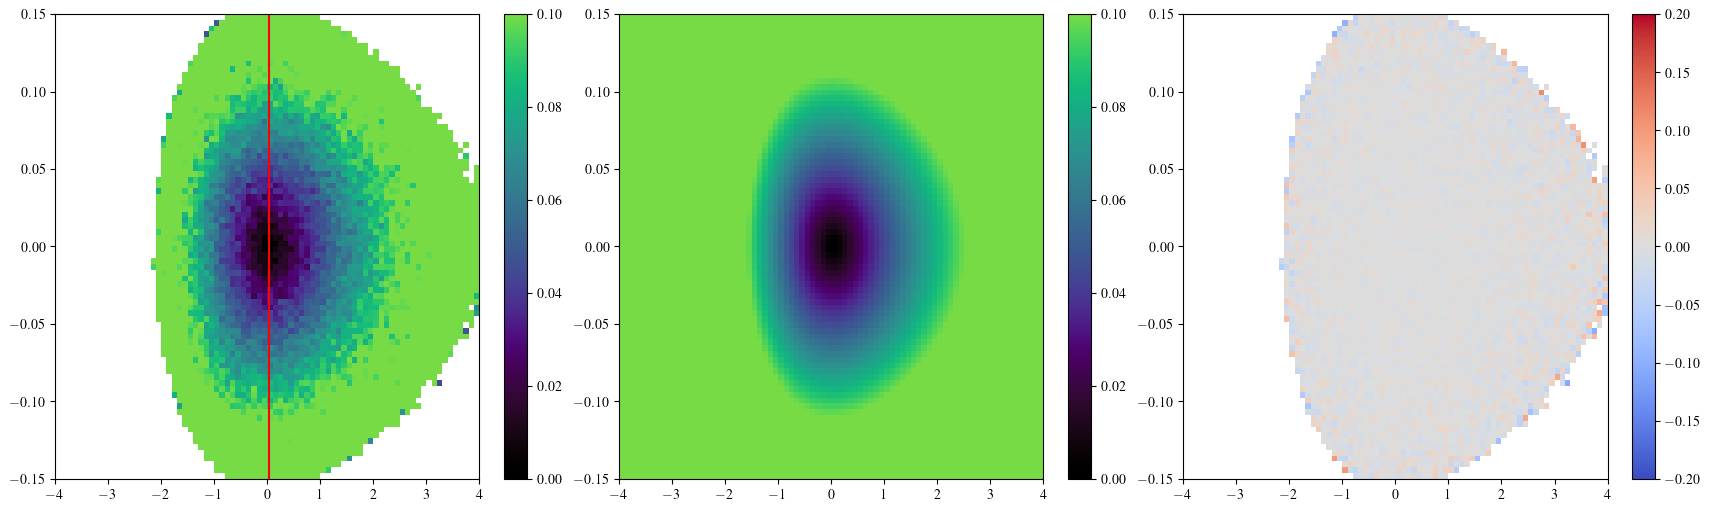

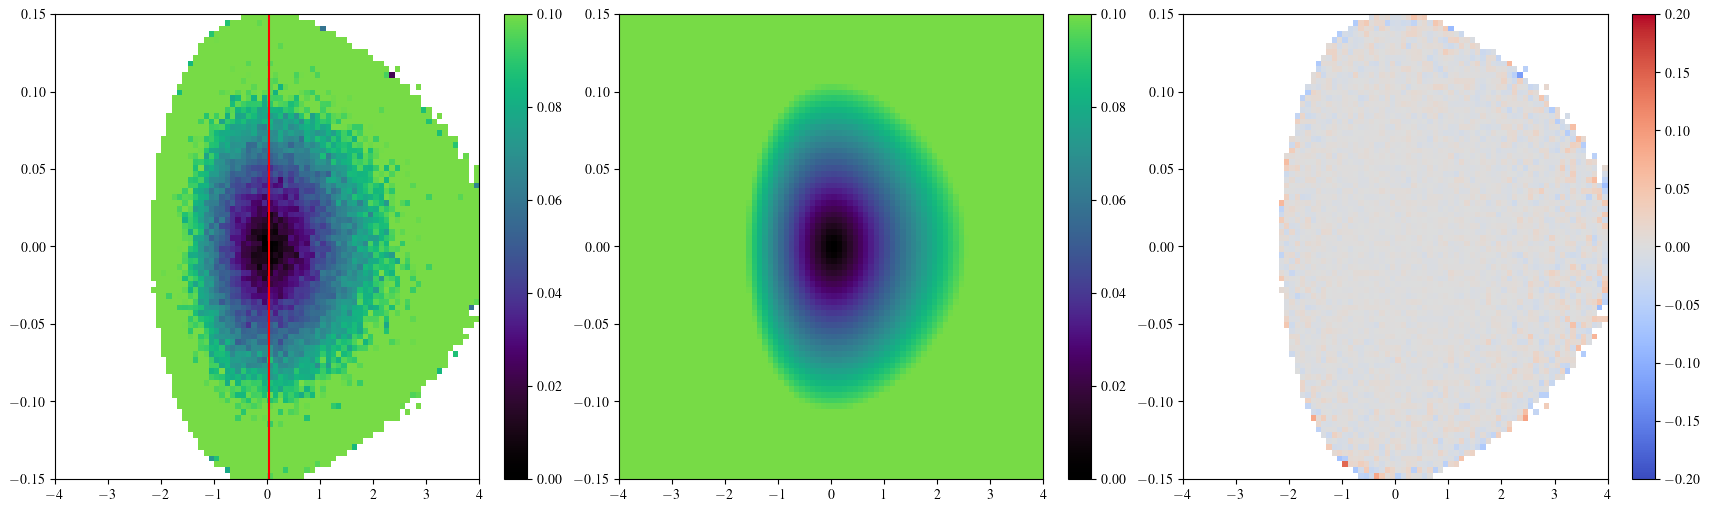

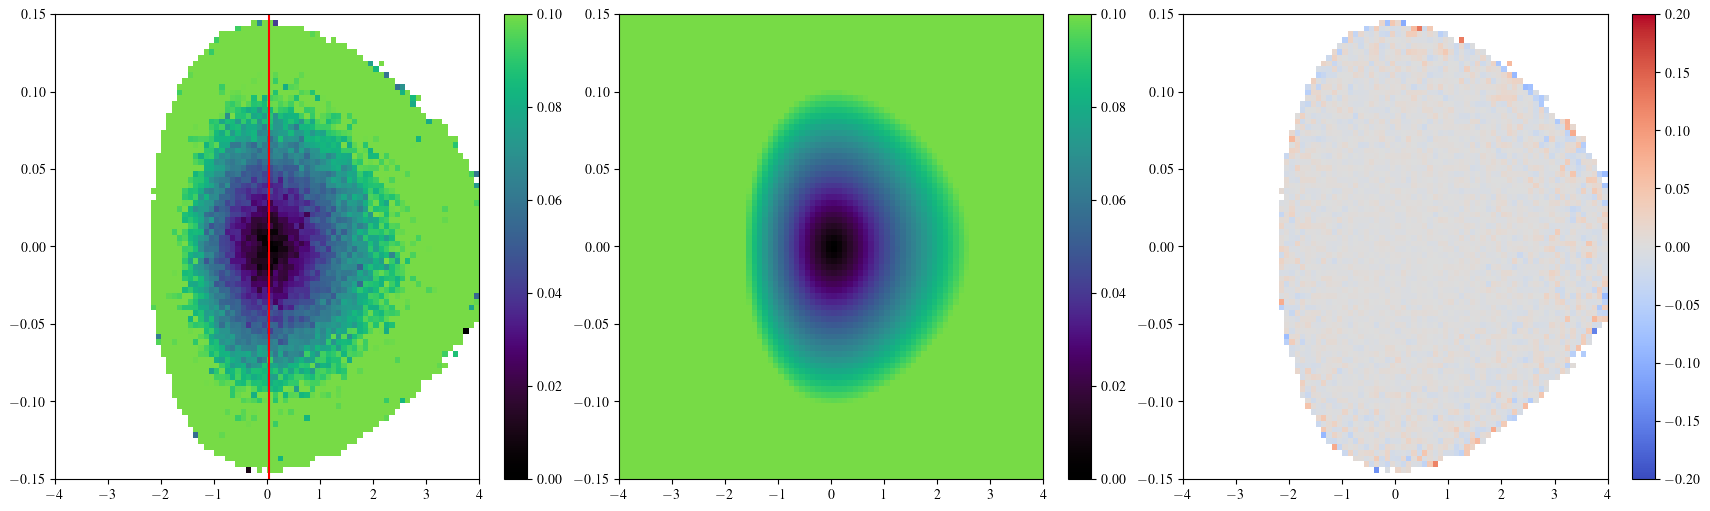

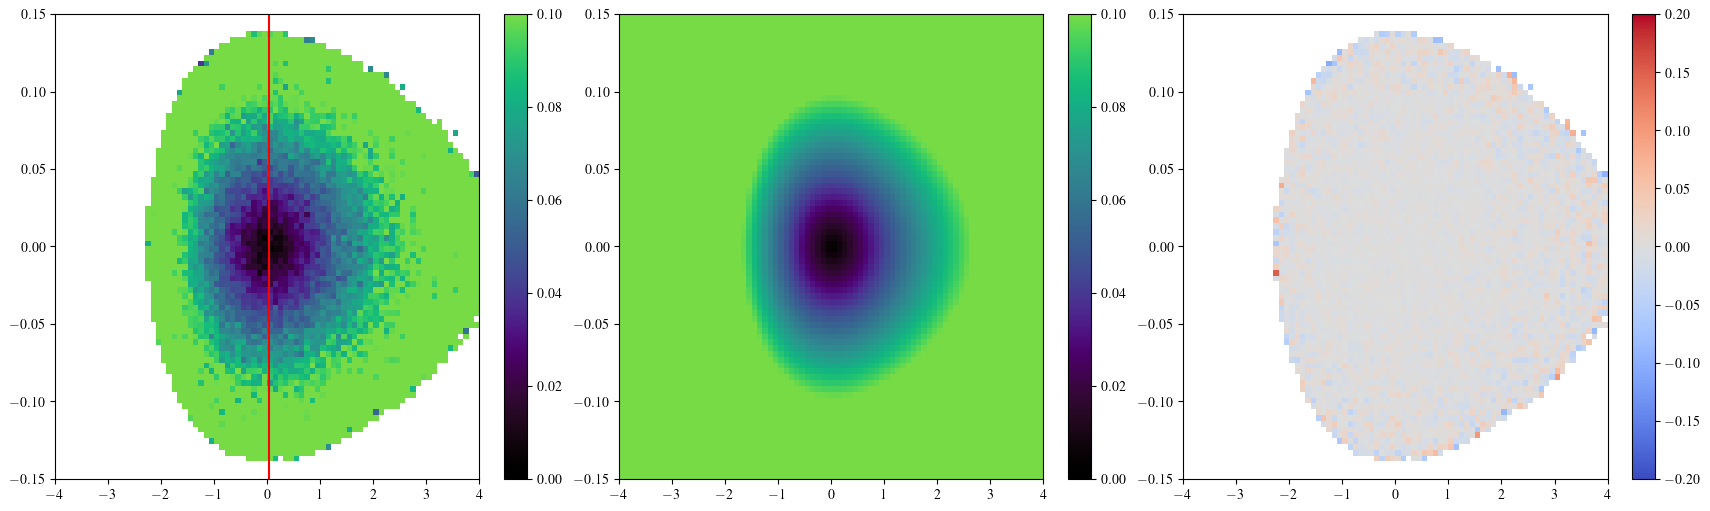

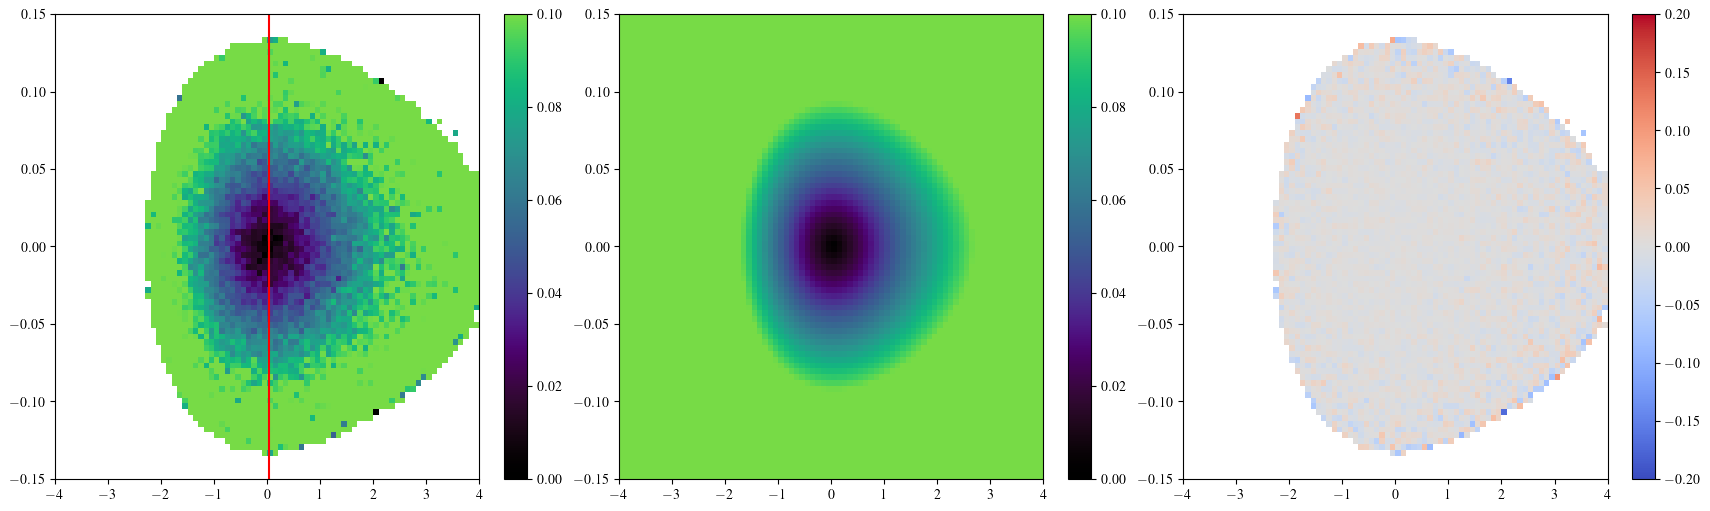

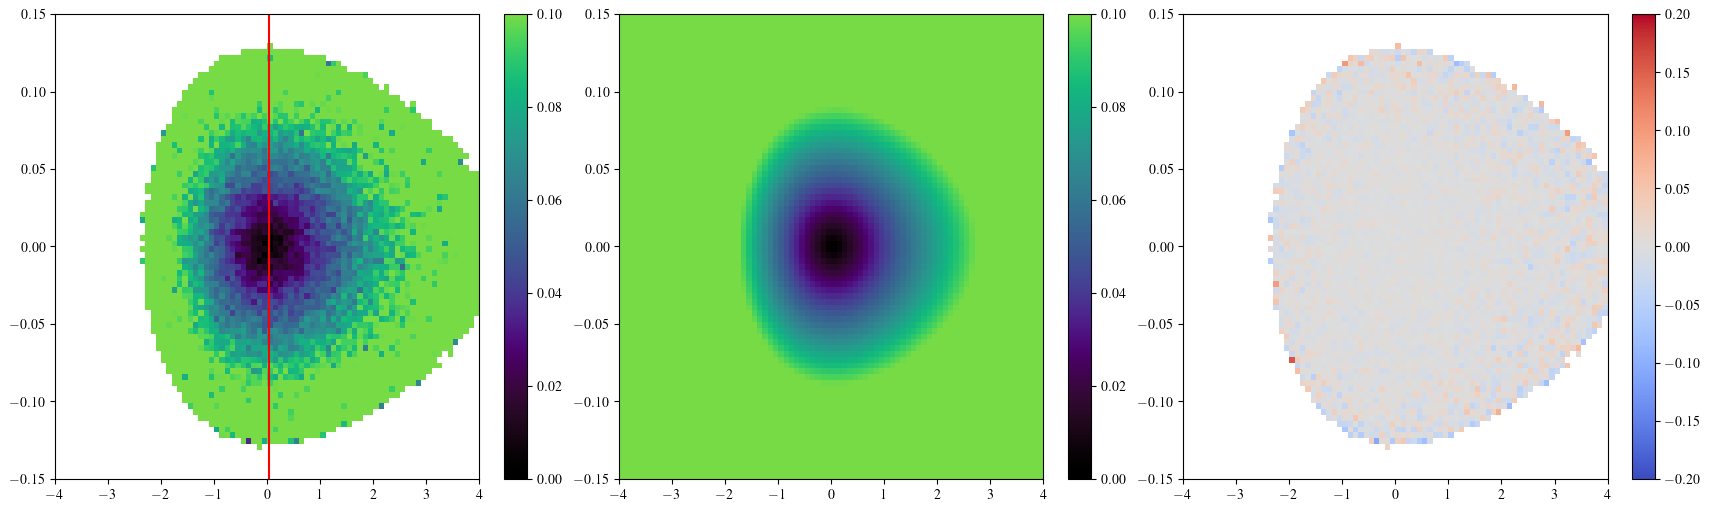

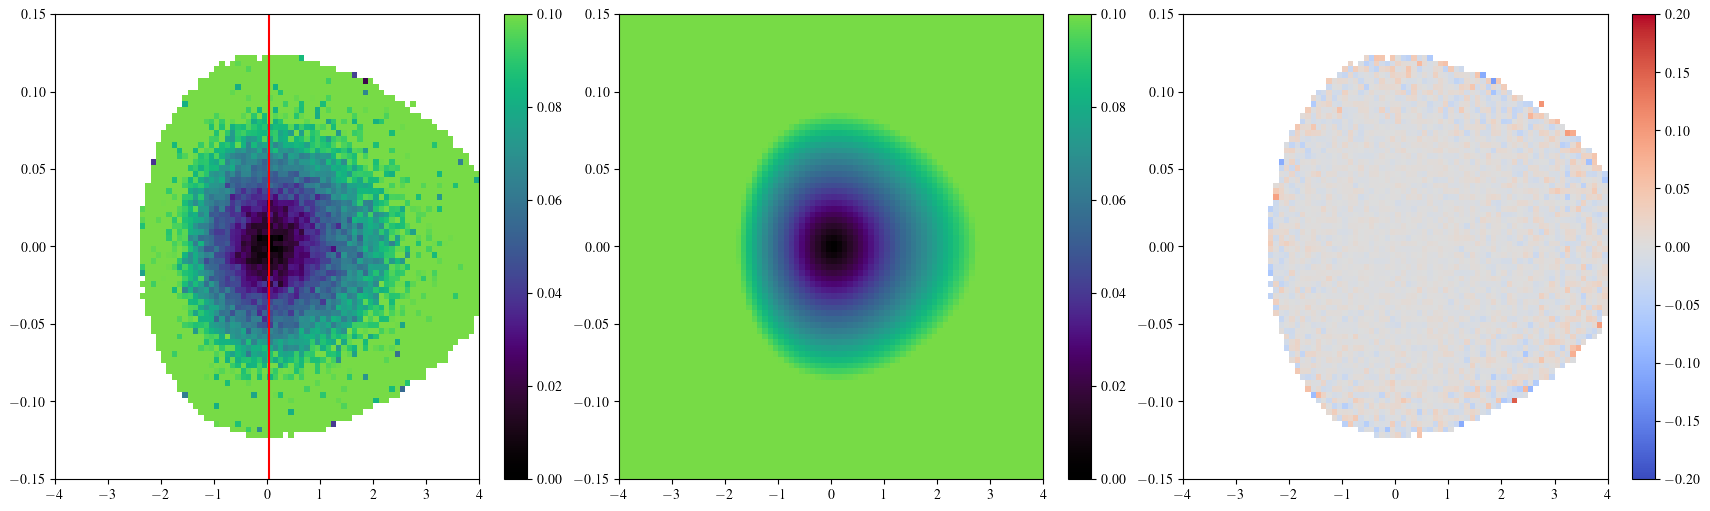

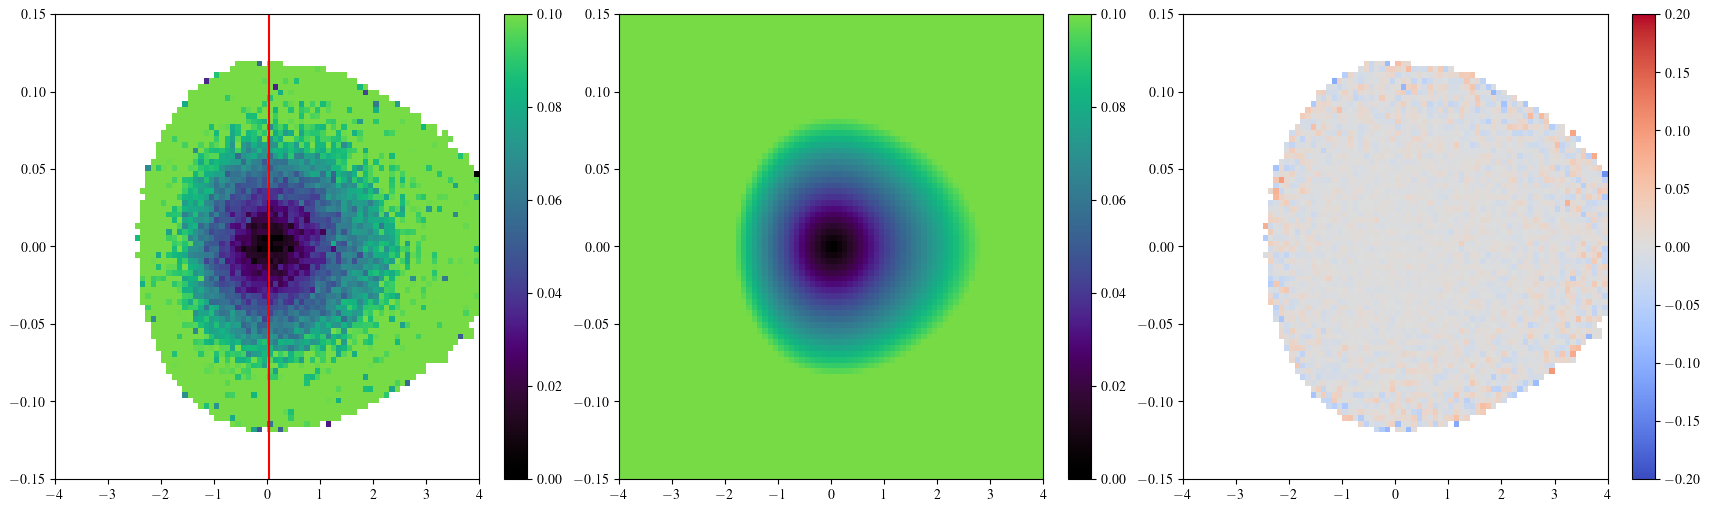

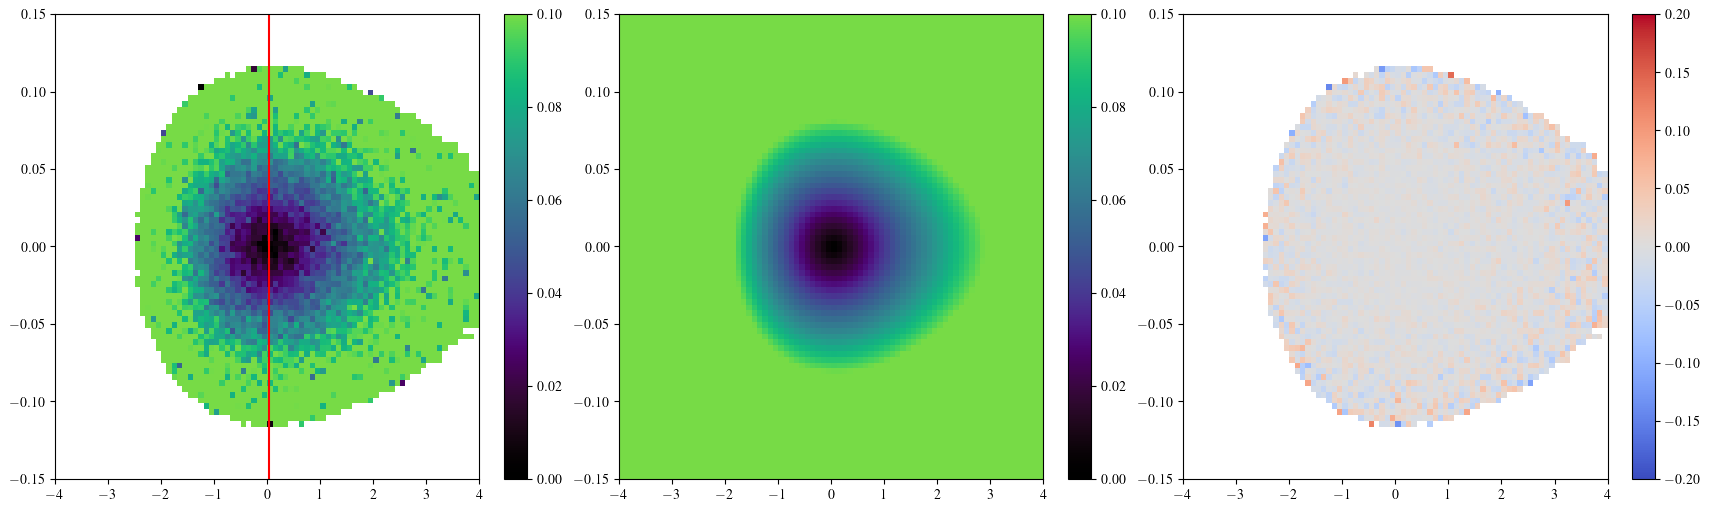

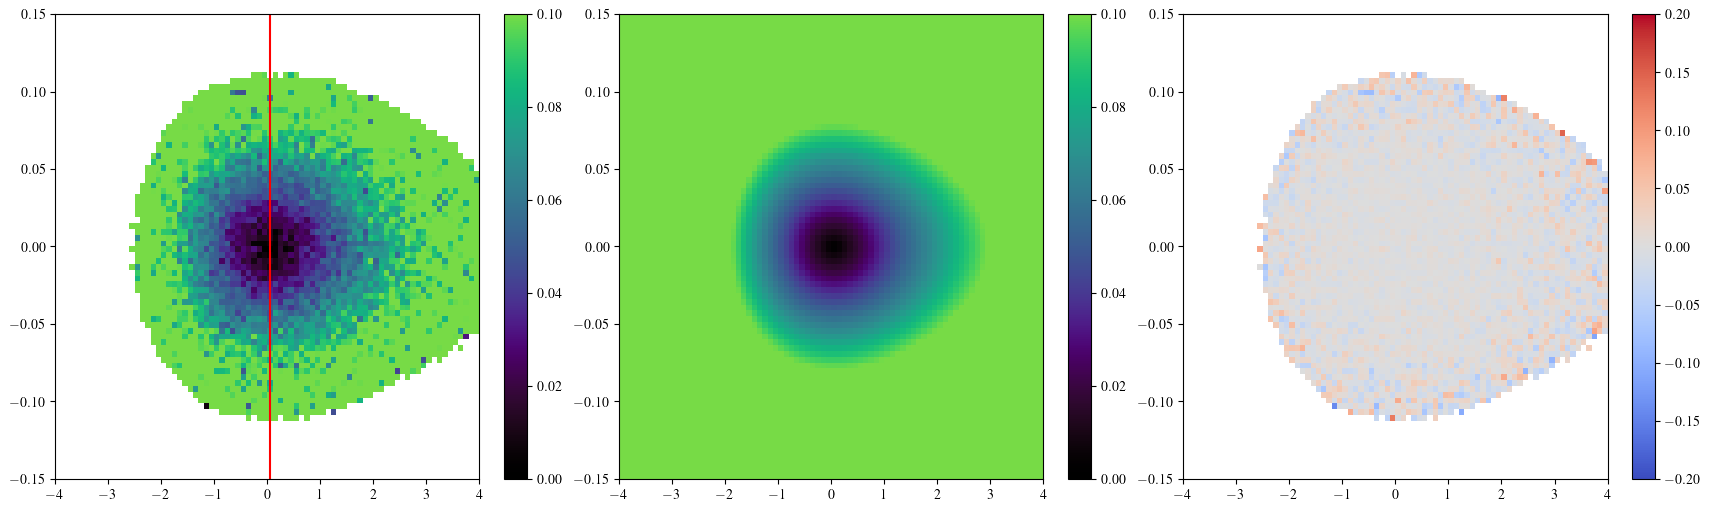

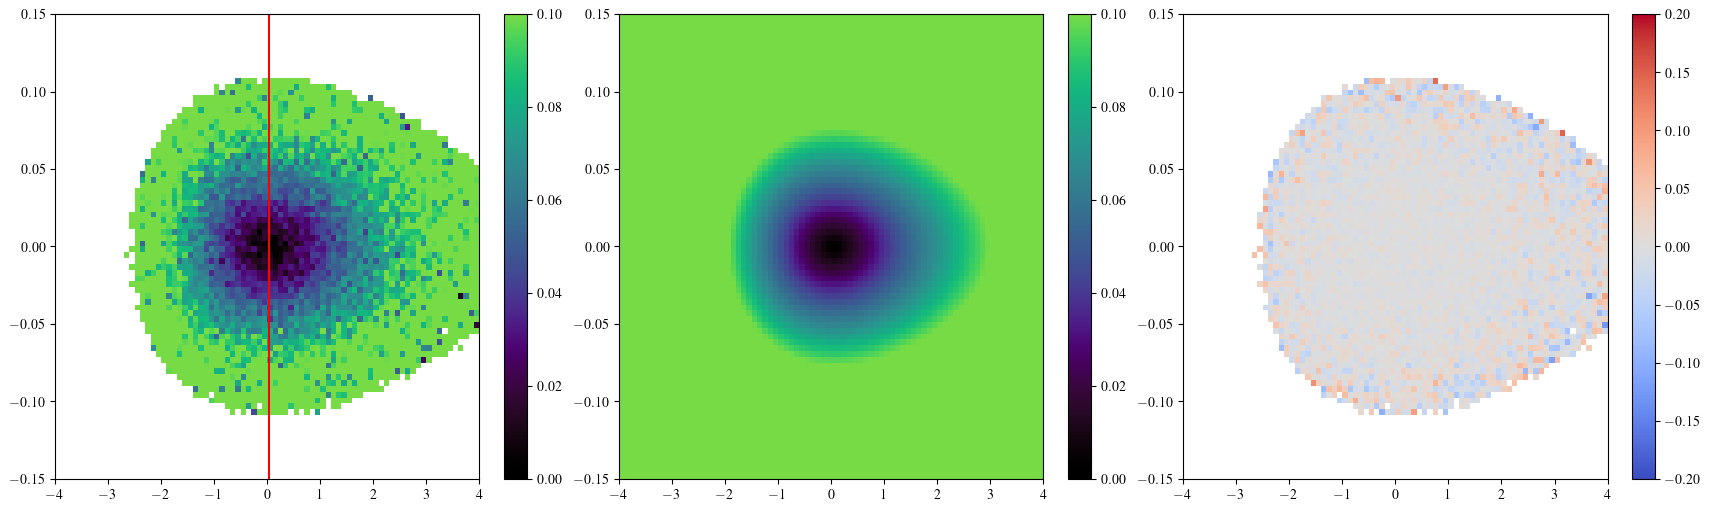

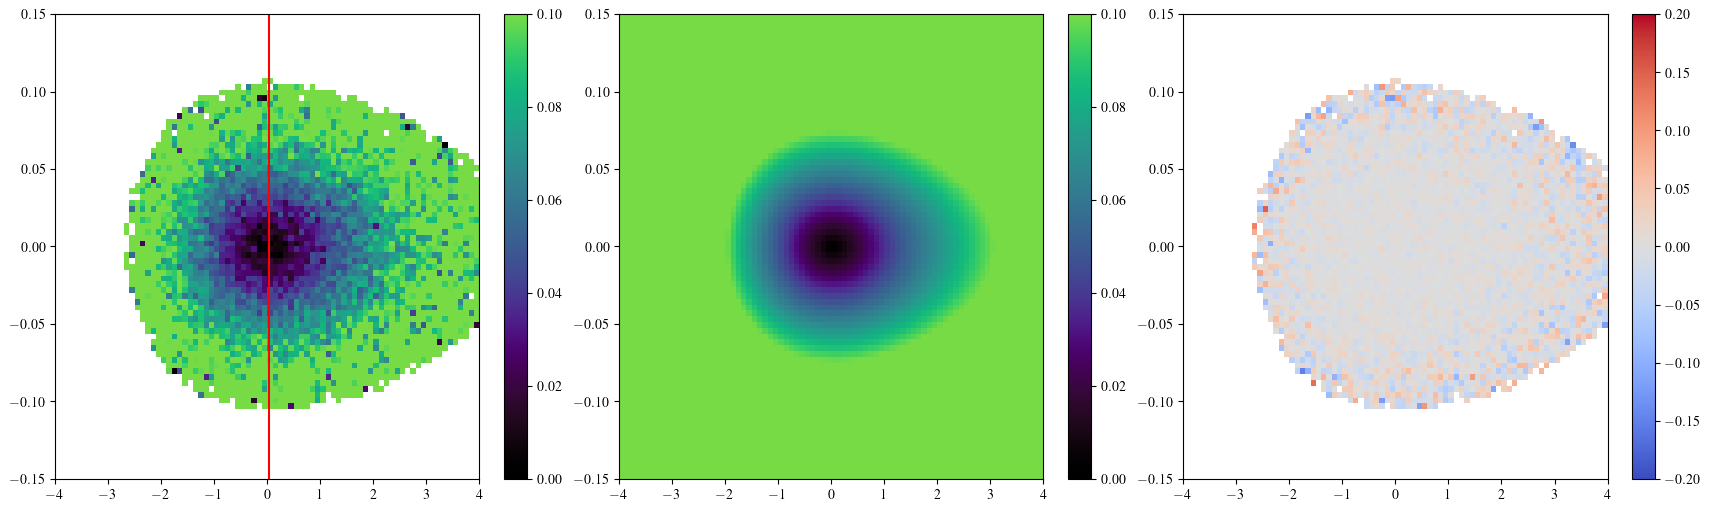

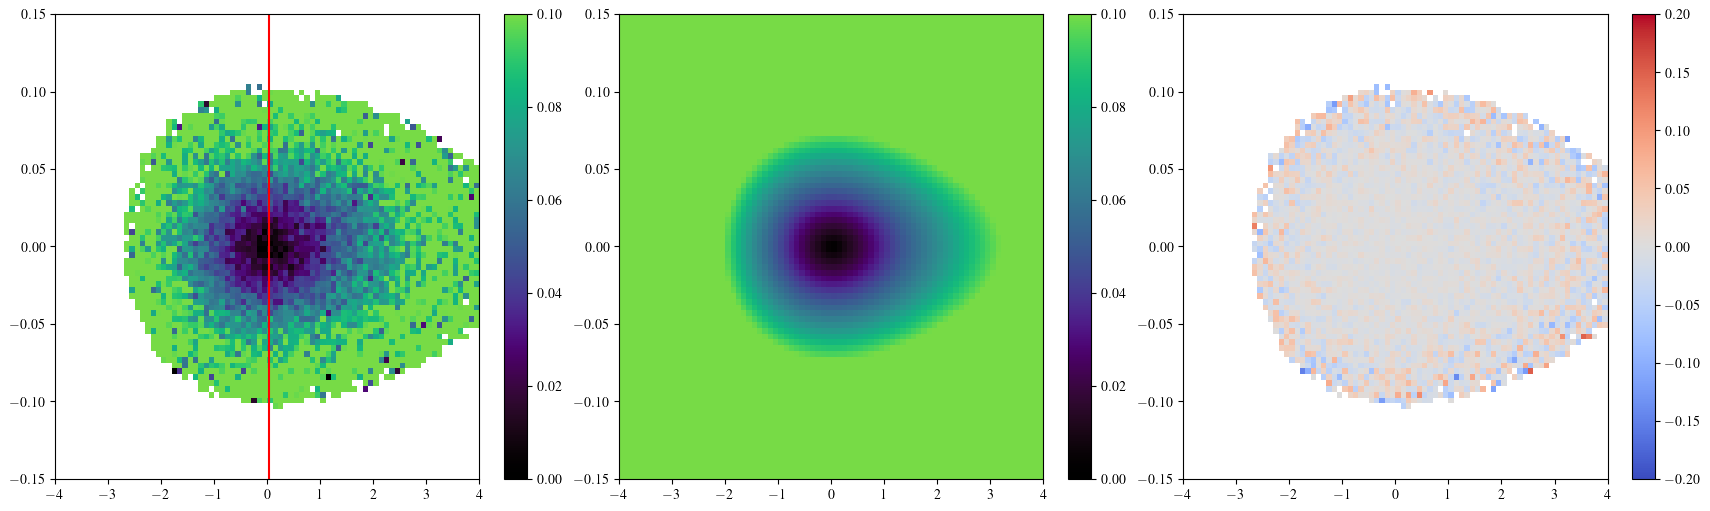

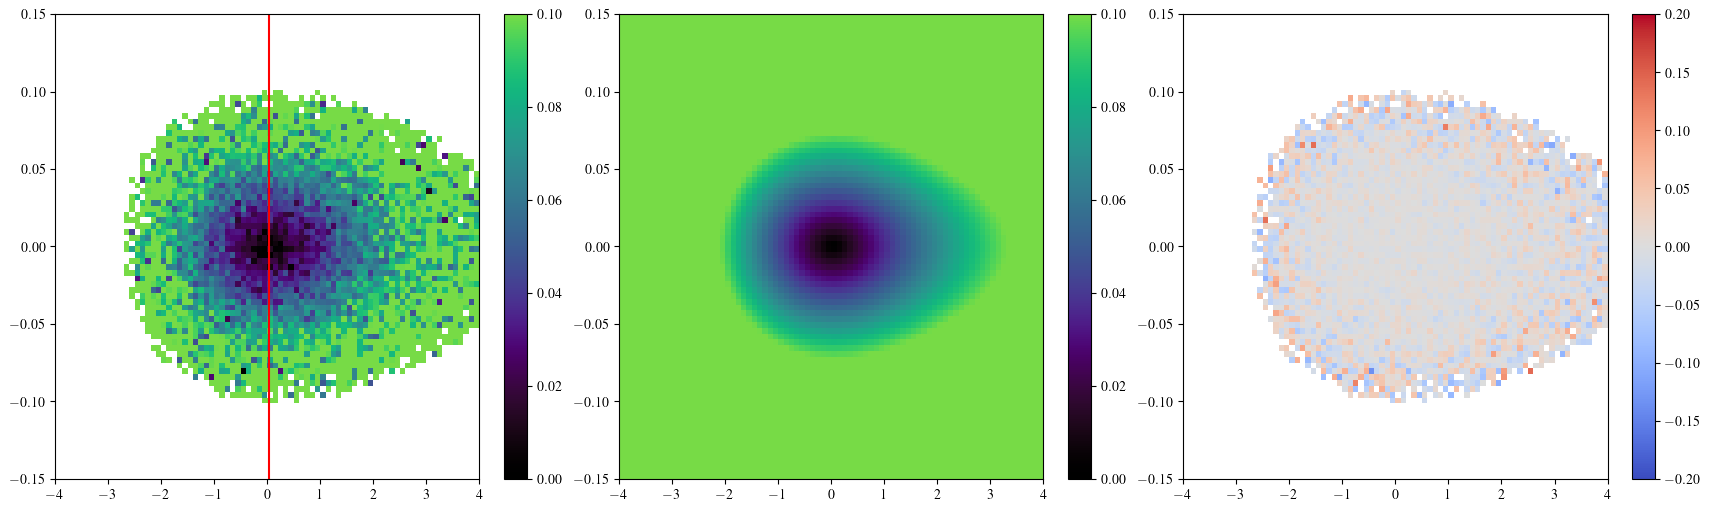

In [252]:
Rgal_cs = np.linspace(5,12,15)
bdatas = []
reses = []


for indx, Rg_c in tqdm.tqdm(enumerate(Rgal_cs[:-1])):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rg > Rg_l*u.kpc) & (Rg <= Rg_r*u.kpc) & (np.abs(data['z'])<0.2) & (data['v_z']<0.03) &(jr.value<200)
    # wmask already has these cuts: (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<2)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<80)
    x_param = deltaR[Rg_mask] 
    y_param = vR[Rg_mask] 
    label = lab[Rg_mask]
    label_err = data['mgfe_err'][Rg_mask]

    bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )

    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
    
    # Plot the data 
    fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
    cs = axes[0].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        bdata["label"],
        cmap=cm.lavender,
        vmin=0.0,
        vmax=0.1,
    )
    axes[0].vlines(res.params['pos0'], -0.15,0.15, color='r')
    fig.colorbar(cs, ax=axes[0])

    model_label = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)

    cs = axes[1].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        model_label,
        cmap=cm.lavender,
        vmin=0.0,
        vmax=0.1,
    )
    fig.colorbar(cs, ax=axes[1])

    # for ss in [1, -1]:
    #     axes[1].scatter(ss * 0.1 * np.sqrt(init_Omega.value), 0., color='tab:green')
    #     axes[1].scatter(0., ss * 0.1 / np.sqrt(init_Omega.value), color='tab:green')

    cs = axes[2].pcolormesh(
        bdata["pos"].value, bdata["vel"].value, (bdata["label"]-model_label), cmap='coolwarm',
        vmin=-0.2,
        vmax=0.2,
    )
    fig.colorbar(cs, ax=axes[2])


    bdatas.append(bdata_clean)
    reses.append(res)


# First see if we can recover the rotation curve

In [253]:
pos0s = []
kappas = []

for i in reses:
    pos0s.append(i.params['pos0'])
    kappas.append(np.exp(i.params['ln_Omega0']))

len(kappas)

14

In [254]:
pos0s

[Array(0.03760316, dtype=float64),
 Array(0.03670758, dtype=float64),
 Array(0.0389259, dtype=float64),
 Array(0.03031525, dtype=float64),
 Array(0.03349144, dtype=float64),
 Array(0.03568565, dtype=float64),
 Array(0.03456177, dtype=float64),
 Array(0.03461705, dtype=float64),
 Array(0.0413607, dtype=float64),
 Array(0.04872362, dtype=float64),
 Array(0.04243357, dtype=float64),
 Array(0.02968221, dtype=float64),
 Array(0.02791898, dtype=float64),
 Array(0.03042956, dtype=float64)]

In [255]:
# vc + -vc * params["pos0"]*u.kpc / Rg_bin


In [256]:
# vcs = np.zeros((len(Rgal_cs[:-1])))
# for indx, Rg_c in tqdm.tqdm(enumerate(Rgal_cs[:-1])):
#     Rg_l, Rg_r = (Rg_c, Rg_c + 1)
#     Rg_mask = (Rg > Rg_l*u.kpc) & (Rg <= Rg_r*u.kpc) & (np.abs(data['z'])<0.2) & (data['v_z']<0.03) &(jr.value<200)
#     vc = vcirc[Rg_mask]
#     vcs[indx] = np.nanmean(vc.value)

In [257]:
Rgal_cs = np.linspace(5,12,15)
bin_centers = Rgal_cs[:-1]+0.5
bin_centers

# vcis = 229.-1.7*(bin_centers-8.275)

array([ 5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. ])

# compute $\Delta_{vc}$ from offset

In [258]:
delta_vc = vcirc*(-np.array(pos0s)/bin_centers)

delta_vc

vc = vcirc+delta_vc

In [261]:
vc

<Quantity [227.43434107, 227.59899403, 227.62861067, 228.00825821,
           227.97739462, 227.9784982 , 228.06886534, 228.11918845,
           228.00298944, 227.88422917, 228.07454411, 228.38207029,
           228.44404814, 228.41930263] km / s>

(200.0, 250.0)

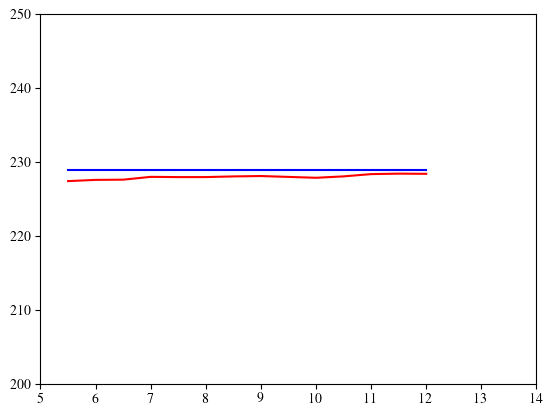

In [260]:
plt.plot(bin_centers, np.tile(vcirc, len(bin_centers)), color='b')
plt.plot(bin_centers, vc, color='r')
plt.xlim(5,14)
plt.ylim(200,250)

# now compute rotation curve from kappa

In [262]:
a_unit = u.km / u.s / u.Myr
x_grid = np.zeros(1) * u.kpc
acc_ = []

for indx, Rg_c in enumerate(bin_centers):
    acc_.append(model.get_acceleration(x_grid, reses[indx].params).to(a_unit))
    

In [263]:
np.array(acc_).real[:,0].shape

(14,)

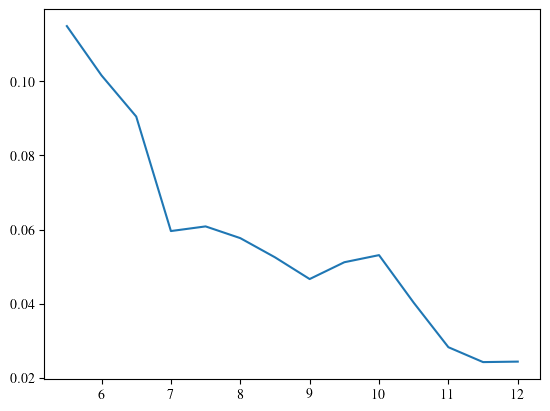

In [264]:
plt.plot(bin_centers, acc_)

In [267]:
dPhi_dR = -np.array(acc_).real[:,0] * a_unit + (bin_centers*u.kpc * (vc)) ** 2 / (bin_centers*u.kpc + x_grid) ** 3


In [268]:
dPhi_dR

<Quantity [9.50346745, 8.72802784, 8.06204996, 7.53591781, 7.02637613,
           6.5866559 , 6.20594851, 5.86673984, 5.54526183, 5.25798718,
           5.02637508, 4.82114683, 4.61684337, 4.42237199] km / (Myr s)>

In [276]:
vrot = np.sqrt(bin_centers * u.kpc * dPhi_dR).to_value(u.km/u.s)

In [277]:
vrot

array([226.07142904, 226.28563005, 226.3615765 , 227.11215884,
       226.99673888, 226.98688785, 227.11030258, 227.21811813,
       226.95832646, 226.74256263, 227.16707473, 227.71666292,
       227.84776858, 227.79361528])

In [278]:
import gala.potential as gp

gala_pot = gp.CCompositePotential(
    disk=gp.MiyamotoNagaiPotential(m=6.91e10, a=3, b=0.25, units=galactic),
    halo=gp.NFWPotential(m=5.4e11, r_s=15.0, units=galactic),
)

In [279]:
true_dPhi_dR = gala_pot.gradient(
    np.array([1.0, 0, 0])[:, None] * (bin_centers*u.kpc + x_grid[None])
)[0]

In [280]:
np.sqrt(bin_centers*u.kpc * true_dPhi_dR).to_value(u.km/u.s)


array([230.4239182 , 230.91326362, 230.92096279, 230.61320873,
       230.10343206, 229.46880577, 228.76162254, 228.01709816,
       227.25871841, 226.50190745, 225.75655082, 225.02873576,
       224.32195514, 223.63794227])

(200.0, 250.0)

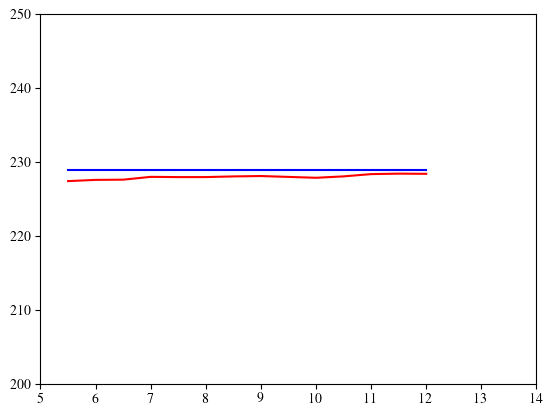

In [282]:
plt.plot(bin_centers, np.tile(vcirc, len(bin_centers)), color='b')
plt.plot(bin_centers, vc, color='r')
plt.xlim(5,14)
plt.ylim(200,250)

(200.0, 250.0)

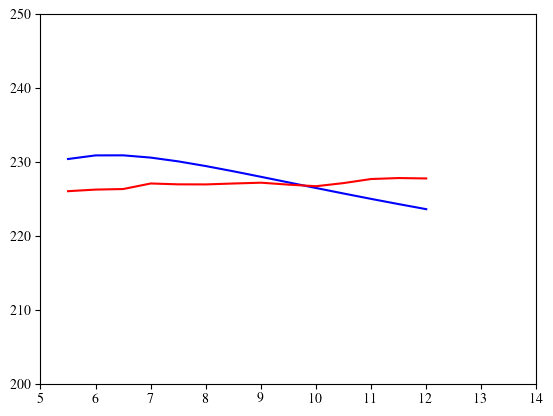

In [283]:
plt.plot(bin_centers, np.sqrt(bin_centers*u.kpc * true_dPhi_dR).to_value(u.km/u.s), color='b')
plt.plot(bin_centers, vrot, color='r')
plt.xlim(5,14)
plt.ylim(200,250)

# now assume a wrong rotation curve

In [284]:
# Eilers rotation curve
Rgal = data['R']*u.kpc
# Rg = data['Rg']*u.kpc
lz = data['J'][:,1]*u.kpc**2/u.Myr
lz = lz.to((u.kpc*u.km)/u.s)
vcirc_w = 200. *u.km/u.s # assuming I don't know this and it is wrong.
Rg_w = lz/vcirc_w
deltaR_w = Rgal-Rg_w

#transform to cylindrical velocities
vR = data['v_R']*u.kpc/u.Myr
# vR = vR.to(u.km/u.s)

In [285]:
x_param = deltaR_w
y_param = vR 
label = lab
label_err = lab_err

bdata = oti.data.get_binned_label(
    pos=x_param.astype(np.float32),
    vel=y_param.astype(np.float32),
    label=label.astype(np.float32),
    label_err=label_err.astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=16,
)


14it [01:49,  7.85s/it]


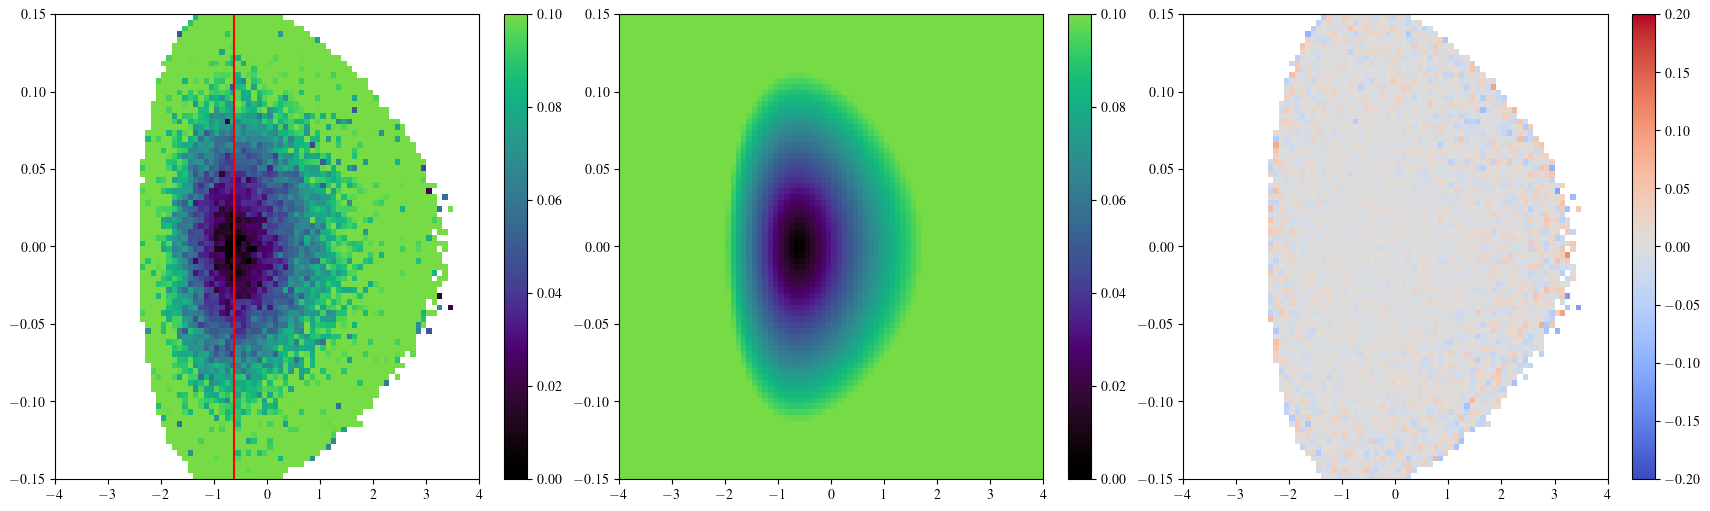

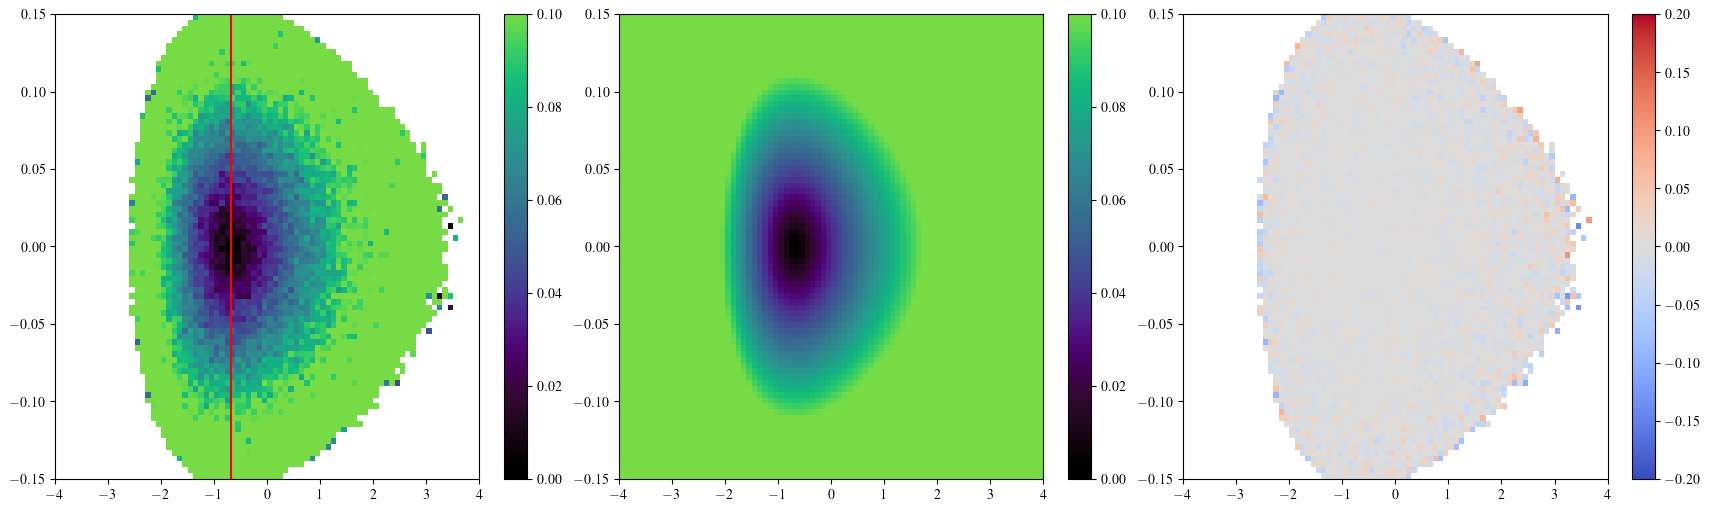

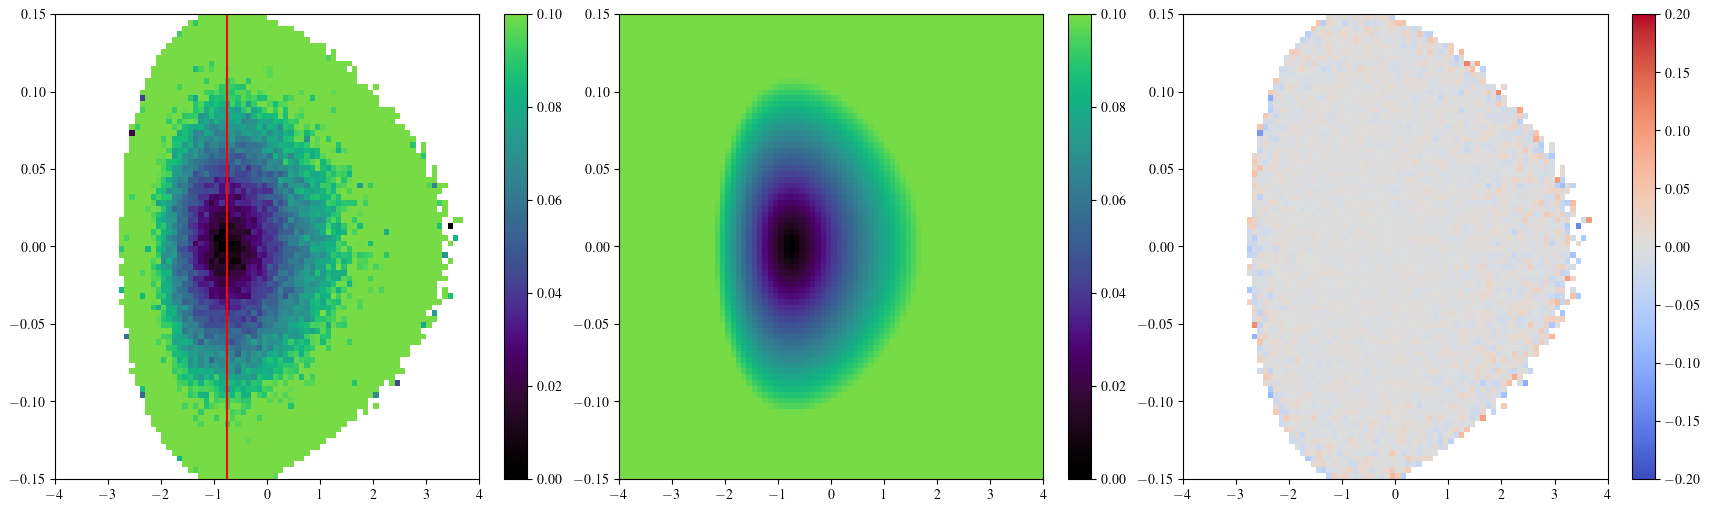

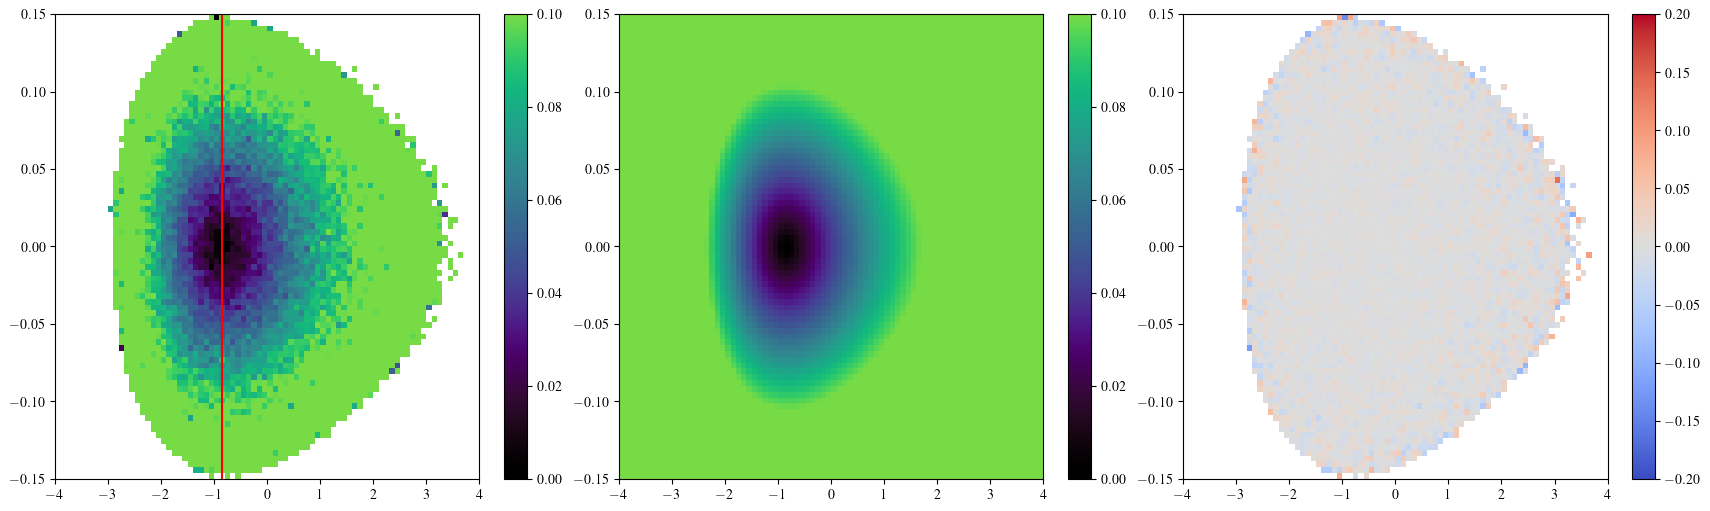

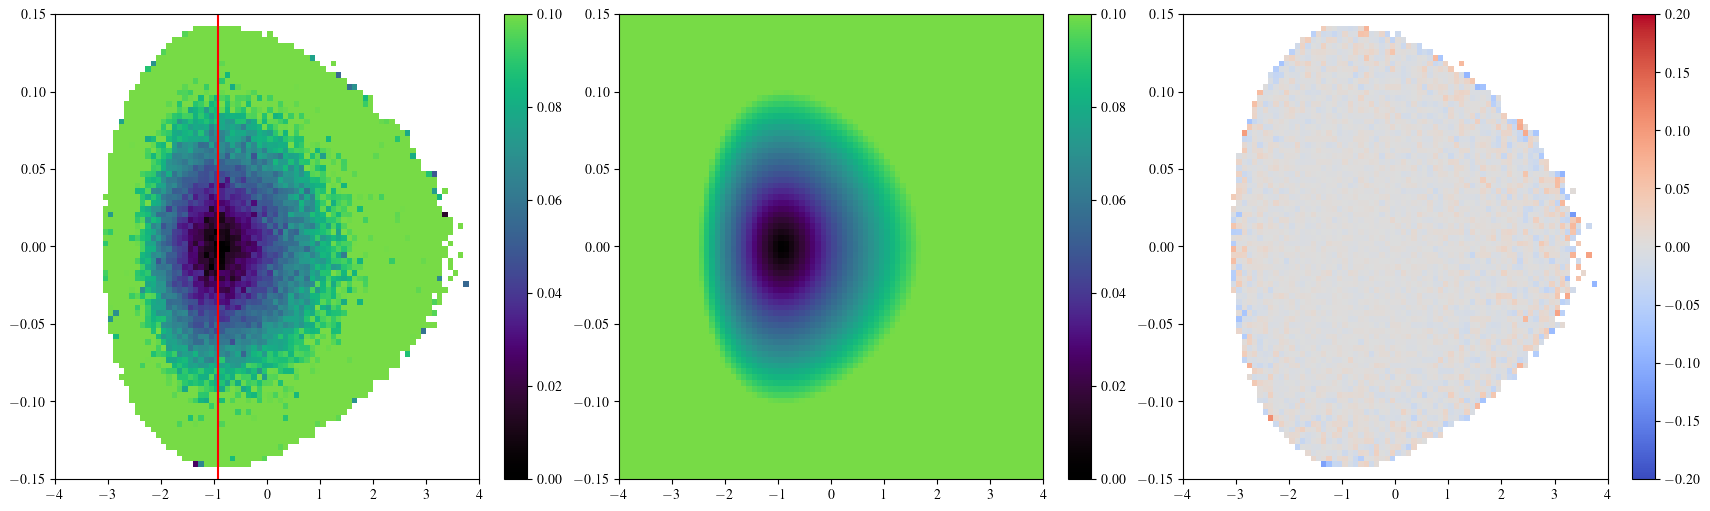

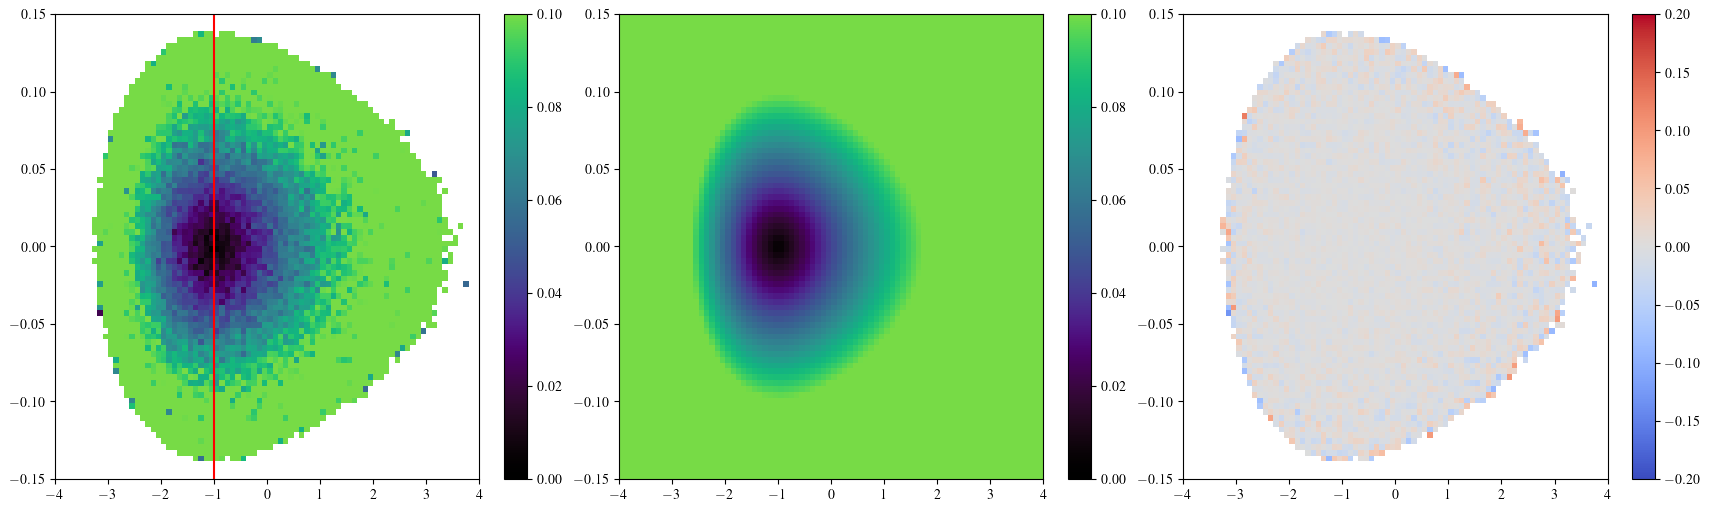

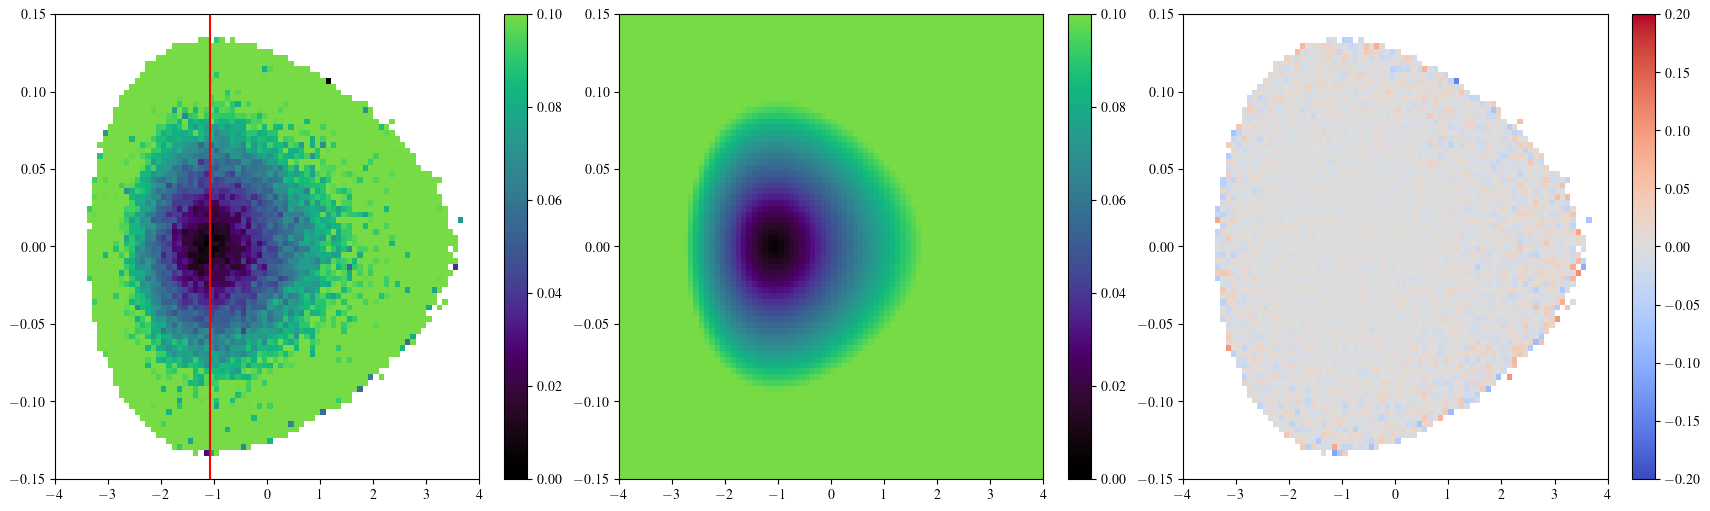

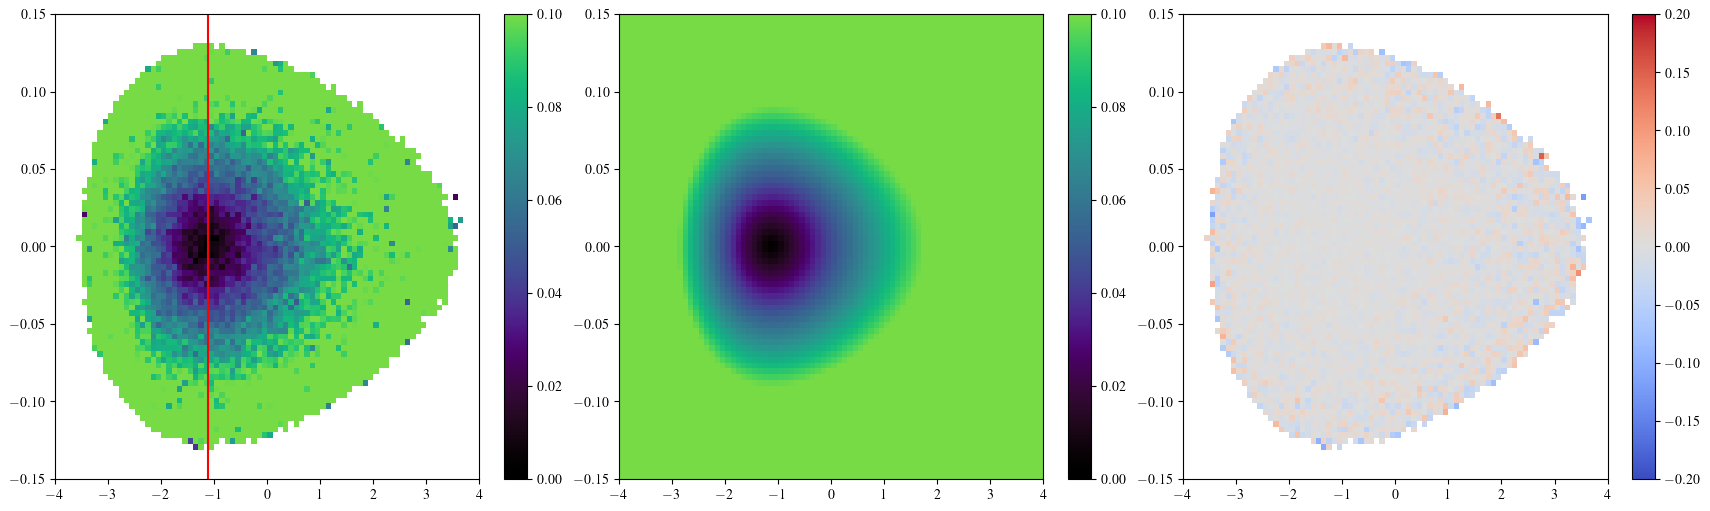

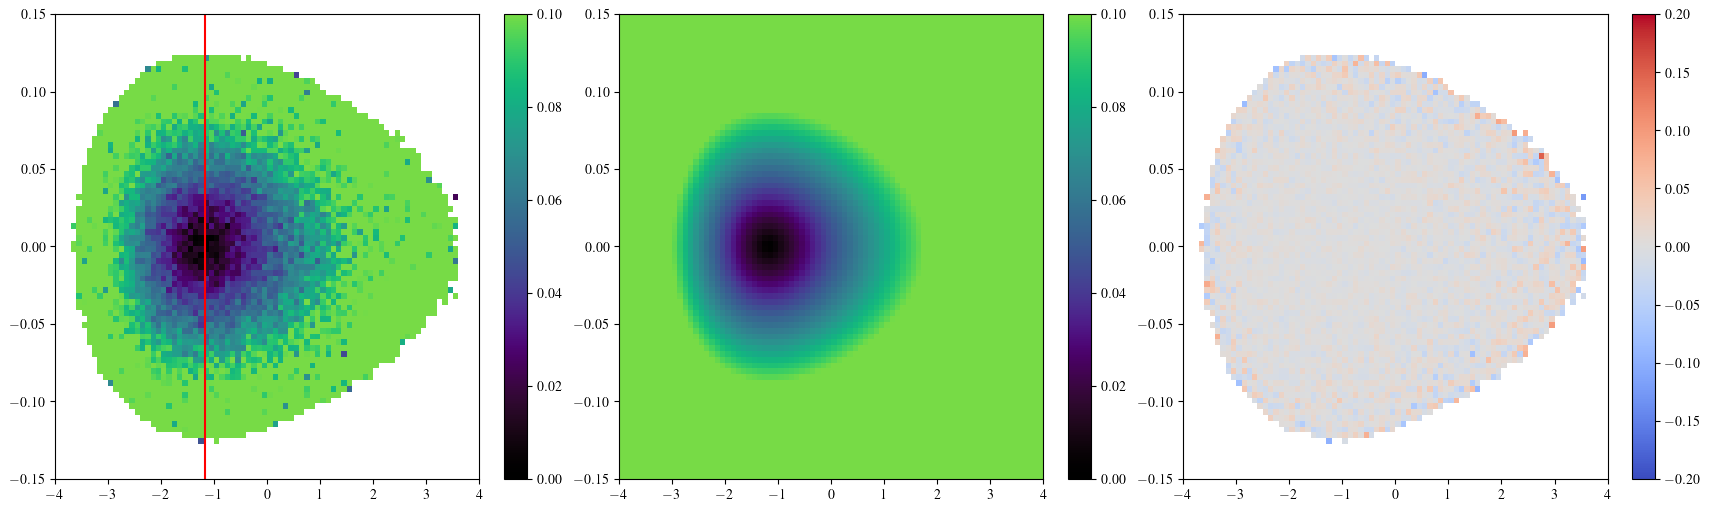

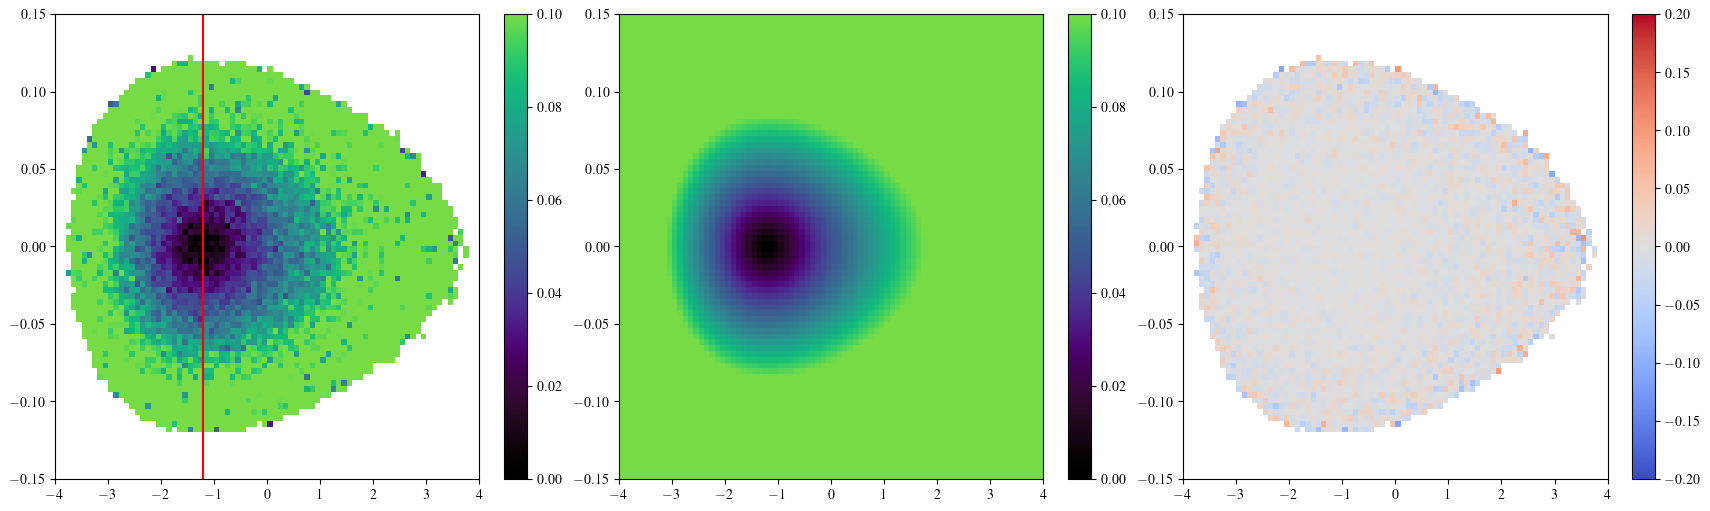

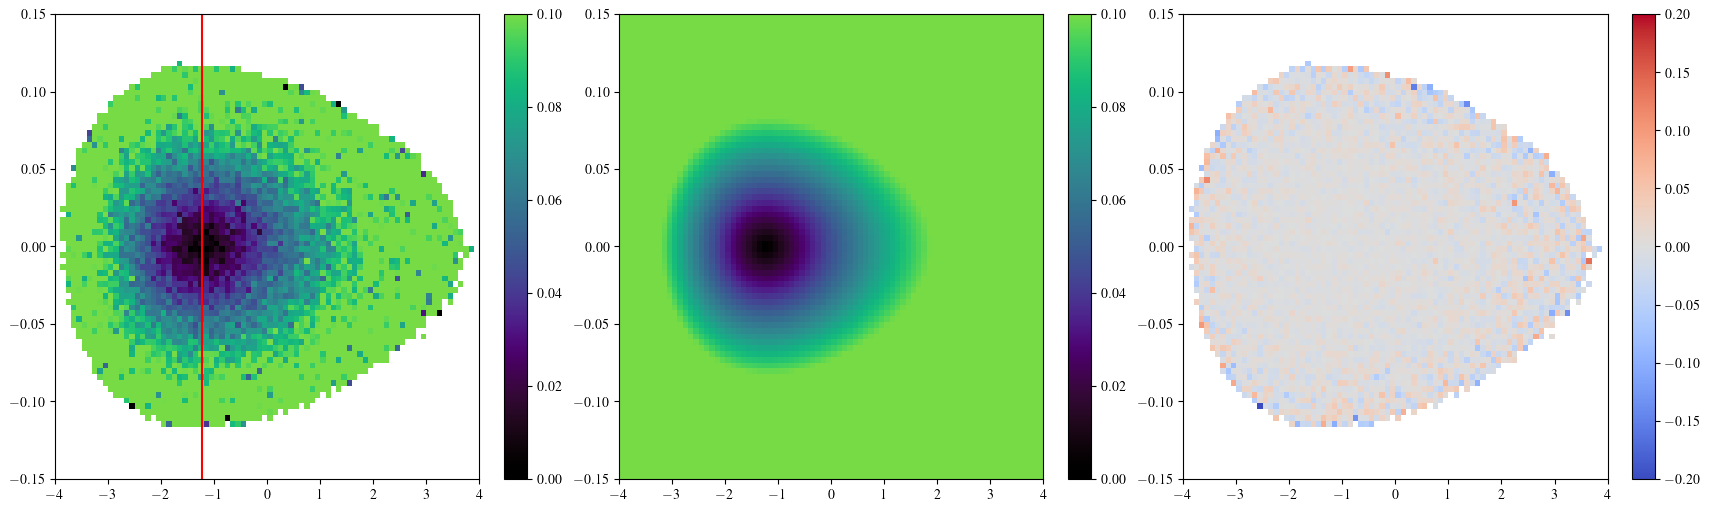

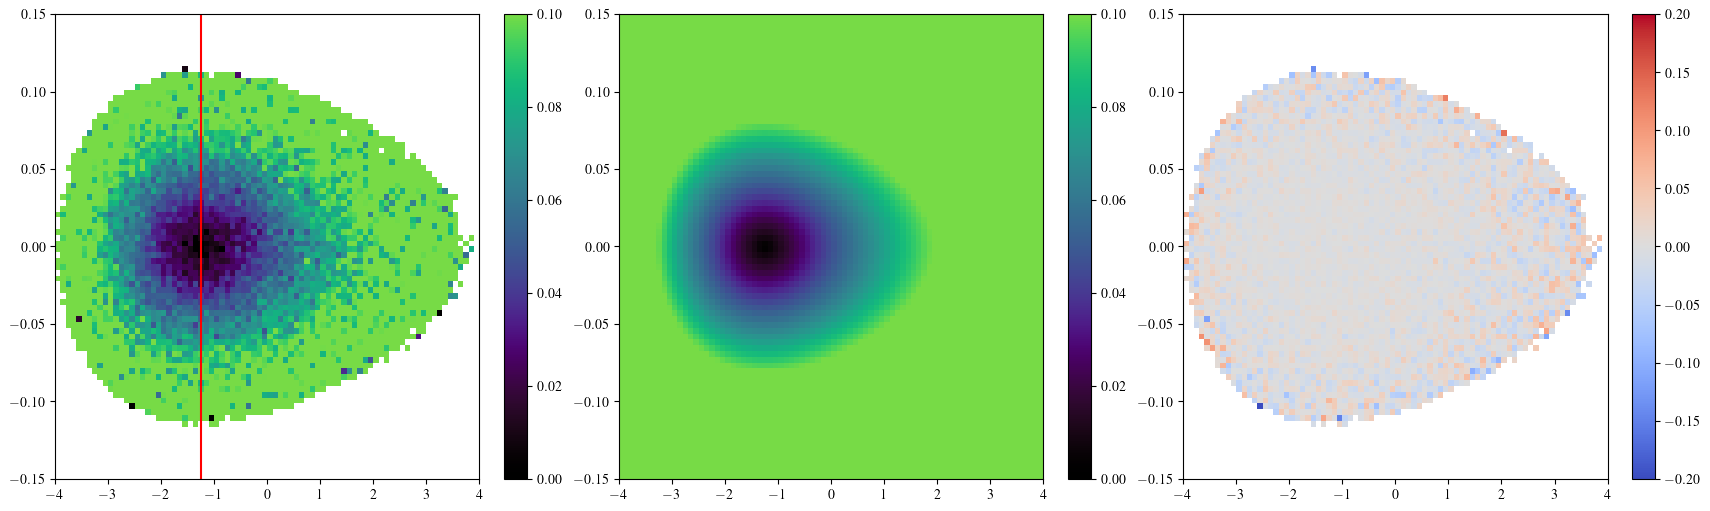

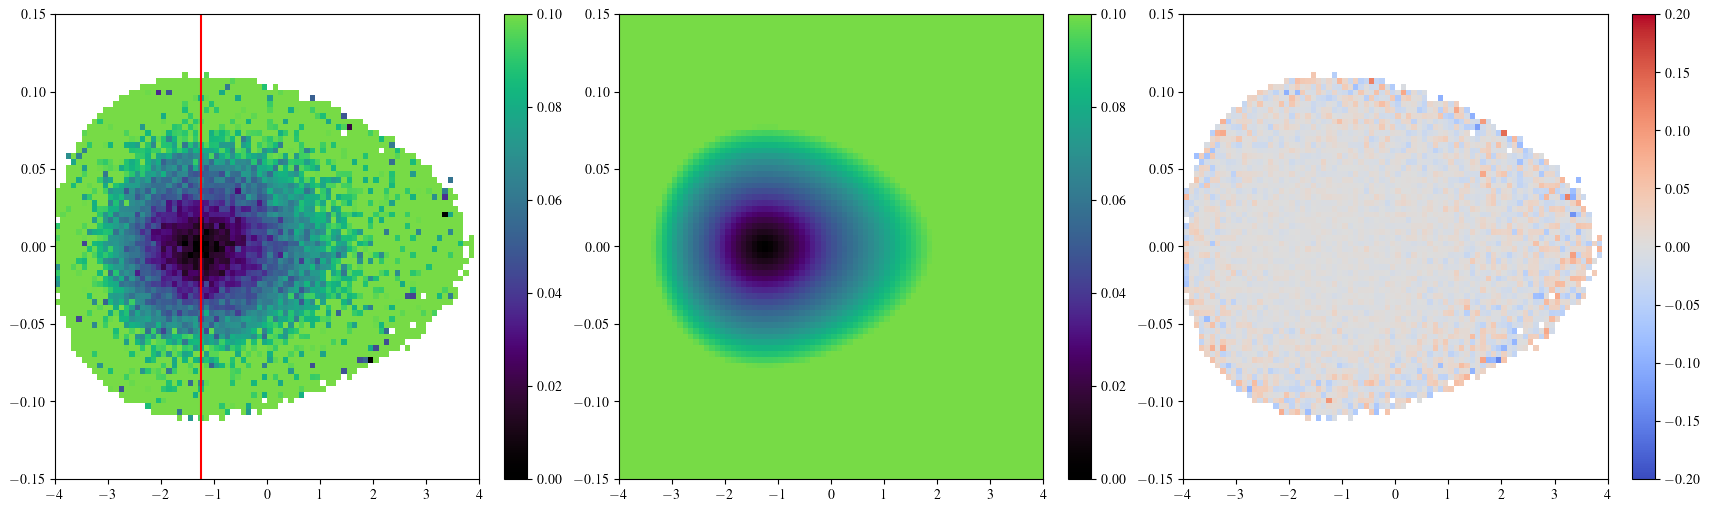

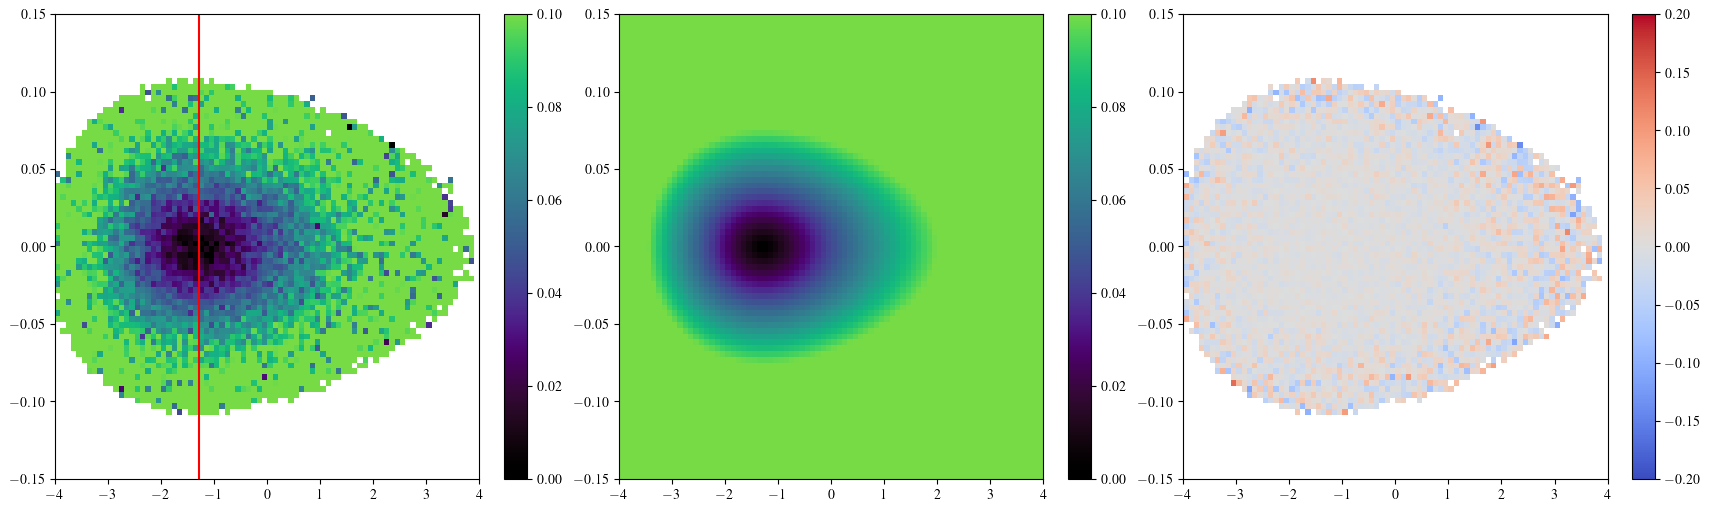

In [286]:
Rgal_cs = np.linspace(5,12,15)
bdatas_w = []
reses_w = []


for indx, Rg_c in tqdm.tqdm(enumerate(Rgal_cs[:-1])):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rg_w > Rg_l*u.kpc) & (Rg_w <= Rg_r*u.kpc) & (np.abs(data['z'])<0.2) & (data['v_z']<0.03) &(jr.value<200)
    # wmask already has these cuts: (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<2)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<80)
    x_param = deltaR_w[Rg_mask] 
    y_param = vR[Rg_mask] 
    label = lab[Rg_mask]
    label_err = data['mgfe_err'][Rg_mask]

    bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )

    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
    
    # Plot the data 
    fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
    cs = axes[0].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        bdata["label"],
        cmap=cm.lavender,
        vmin=0.0,
        vmax=0.1,
    )
    axes[0].vlines(res.params['pos0'], -0.15,0.15, color='r')
    fig.colorbar(cs, ax=axes[0])

    model_label = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)

    cs = axes[1].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        model_label,
        cmap=cm.lavender,
        vmin=0.0,
        vmax=0.1,
    )
    fig.colorbar(cs, ax=axes[1])

    # for ss in [1, -1]:
    #     axes[1].scatter(ss * 0.1 * np.sqrt(init_Omega.value), 0., color='tab:green')
    #     axes[1].scatter(0., ss * 0.1 / np.sqrt(init_Omega.value), color='tab:green')

    cs = axes[2].pcolormesh(
        bdata["pos"].value, bdata["vel"].value, (bdata["label"]-model_label), cmap='coolwarm',
        vmin=-0.2,
        vmax=0.2,
    )
    fig.colorbar(cs, ax=axes[2])


    bdatas_w.append(bdata_clean)
    reses_w.append(res)


In [310]:
pos0s_w = []
kappas_w = []

for i in reses_w:
    pos0s_w.append(i.params['pos0'])
    kappas_w.append(np.exp(i.params['ln_Omega0']))


In [311]:
vcirc_w

<Quantity 200. km / s>

(180.0, 240.0)

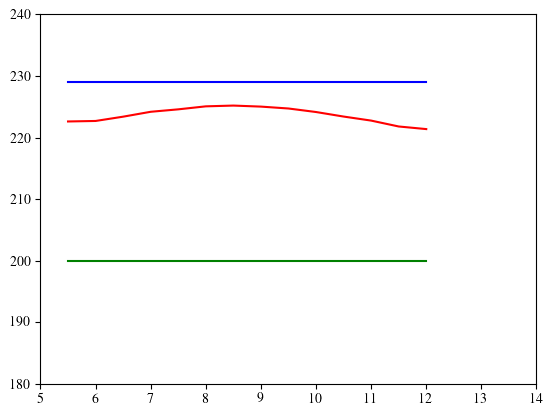

In [312]:
delta_vc_w = vcirc_w*(-np.array(pos0s_w)/bin_centers)

delta_vc_w

vc_w = vcirc_w+delta_vc_w

plt.plot(bin_centers, np.tile(vcirc, len(bin_centers)), color='b')
plt.plot(bin_centers, np.tile(vcirc_w, len(bin_centers)), color='g')
plt.plot(bin_centers, vc_w, color='r')
plt.xlim(5,14)
plt.ylim(180,240)

In [313]:
vc_w

<Quantity [222.60225423, 222.68454674, 223.38121729, 224.17509466,
           224.57149555, 225.05830533, 225.18298924, 225.01527004,
           224.70796592, 224.13676071, 223.39975985, 222.74445467,
           221.78853084, 221.36525604] km / s>

In [314]:
acc_w = []

for indx, Rg_c in enumerate(bin_centers):
    acc_w.append(model.get_acceleration(x_grid, reses_w[indx].params).to(a_unit))
    

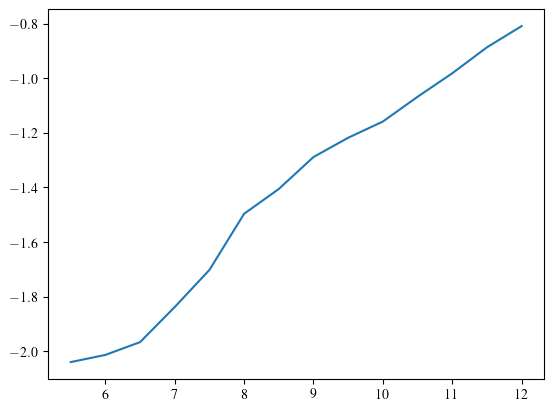

In [315]:
plt.plot(bin_centers, acc_w)

In [316]:
dPhi_dR_w = -np.array(acc_w).real[:,0] * a_unit + (bin_centers*u.kpc * (vc)) ** 2 / (bin_centers*u.kpc + x_grid) ** 3


In [317]:
vrot_w = np.sqrt(bin_centers * u.kpc * dPhi_dR_w).to_value(u.km/u.s)
vrot_w

array([250.39107093, 252.21715046, 253.60082504, 254.10184481,
       253.88108473, 252.34926908, 252.38403258, 251.7502291 ,
       251.59393921, 251.51667924, 250.96431724, 250.43826847,
       249.31677617, 248.33112844])